In [360]:
###########################################################################                                                                         #
# Responsible for pre-processing sensor data and building, training, &    #
# evaluating the model.                                                   #
#                                                                         #
# required input:                                                         #
###########################################################################

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import Dense,BatchNormalization,LSTM,Input,Flatten
from keras.callbacks import Callback

from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
    
PROGRAMMATIC = True

###########################################################################
# A callback to give us the r-squared value for our models predictions    #
# during training.                                                        #
###########################################################################

class R2Callback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        X_test, y_test = self.test_data
        pred = self.model.predict(X_test)
        r2 = r2_score(pred,y_test)
        print('r2 score: {},\n'.format(r2))



In [361]:
num_attributes=8
num_targets=3

In [362]:
import tensorflow as tf
from keras import backend as K

num_cores = 4
CPU=1
GPU=0
if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

In [363]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [364]:

######################################################################################
#                             getData()                                              #
# Get the data out of the files and in a nice format.                                #
# Parameters:                                                                        #
#     files : a list of files with the data in it                                    #
#     debug : a debug flag.                                                          #
######################################################################################

def getData(files,debug):

    data    = np.empty((0,num_attributes)) #initializing empty array with proper shape
    targets = np.empty((0,num_targets   )) #empty array for targets
    batches = np.array([])

    for f in files:
        print(f)
        #grab the relative pathname and we can save the data for later.
        relative_path = f[f.rfind('/')+1:]

        full_data = np.loadtxt(f,delimiter = ',')

        ###########################################################
        # The first three columns are targets, the rest features, #
        # and we're predicting the difference in each feature     #
        # from one time point to the next.                        #
        ###########################################################

        processed_data    = full_data[:-1,3:]
        processed_targets = full_data[1:,:3]-full_data[:-1,:3]

        batch = processed_data.shape[0]

        if debug :
            print("full_data.shape: {}".format(full_data.shape))
            print("processed_data.shape: {}".format(processed_data.shape))
            print("processed_target.shape: {}".format(processed_targets.shape))

        data    = np.append(data, processed_data, axis=0)
        targets = np.append(targets, processed_targets, axis=0)
        batches = np.append(batches,[batch])

        np.savetxt('Data/Processed/' + relative_path, processed_data, delimiter=',', fmt = '%f')
    scalar_train = MinMaxScaler()
    scalar_train = scalar_train.fit(data)
    data = scalar_train.transform(data)
    scalar_targets = MinMaxScaler()
    scalar_targets = scalar_targets.fit(targets)
    targets= scalar_targets.transform(targets)
    
    if debug :
        print("data[0:10]: \n{}".format(data[0:10]))
        print("targets[0:10]: \n{}".format(targets[0:10]))
        print("batches: \n{}".format(batches))
    return data,targets,batches



In [365]:

######################################################################################
#                             split_array()                                          #
# splits data into chunks , each array will be of same sizest.                       #
# Parameters:                                                                        #
#     files : a list of files with the data in it                                    #
#     debug : a debug flag.                                                          #
######################################################################################


def split_array(x,split_size=8,final_shape=8,test_only=False):
    counter = 0
    block = list();
    temp = list();
    print(x.shape)
    for i in range(0,x.shape[0]):
        block.append(x[i])
        counter = counter + 1
        if counter == split_size:
            block_list = list();
            for i in range(0,final_shape):
                block_list.append(block[-1])
            block = np.array(block_list)
            block = np.resize(block_list,(final_shape,final_shape))
            temp.append(block)
            counter = 0
            block = list();
    return np.array(temp)
        
        

In [366]:
files=["/home/crumpler/DMproject-master/Data/Clean/layton_1.1.csv"]

In [367]:
data,targets,samples = getData(files,True)
print(targets.shape)
data = split_array(data,8)
data = np.array(data)
targets = split_array(targets,8,8)
last_value = targets[:,7,:]
last_value = last_value[:,0:3]
targets = np.array(targets)
data =data.reshape((data.shape[0],data.shape[1],data.shape[2],1))
targets =targets.reshape((targets.shape[0],targets.shape[1],targets.shape[2],1))
targets_mask = np.ma.masked_where(targets >0, targets).mask
print(data.shape)
print("Targets:{}".format(last_value.shape))
print("Targets_mask:{}".format(targets_mask.shape))
print(targets_mask.shape)
print(np.count_nonzero(targets_mask))

/home/crumpler/DMproject-master/Data/Clean/layton_1.1.csv
full_data.shape: (25189, 11)
processed_data.shape: (25188, 8)
processed_target.shape: (25188, 3)
data[0:10]: 
[[0.59968229 0.44965885 0.43877999 0.20585233 0.05528701 0.67496542
  0.10366168 0.02212389]
 [0.59771749 0.4501581  0.4386921  0.20551208 0.05558912 0.67496542
  0.10417741 0.02212389]
 [0.60047657 0.44907639 0.43816472 0.20551208 0.05558912 0.67496542
  0.10417741 0.02149178]
 [0.59901342 0.44949243 0.4386042  0.20585233 0.05498489 0.6746888
  0.10417741 0.02149178]
 [0.59938966 0.44932601 0.43904368 0.20585233 0.05498489 0.6746888
  0.10469314 0.02085967]
 [0.59909703 0.44932601 0.43877999 0.20619258 0.05528701 0.6746888
  0.10417741 0.02085967]
 [0.59997492 0.44890997 0.43913158 0.20619258 0.05528701 0.6746888
  0.10159876 0.02085967]
 [0.60018394 0.44940922 0.4386042  0.20619258 0.05528701 0.6746888
  0.09902011 0.02085967]
 [0.60097822 0.44949243 0.43877999 0.20619258 0.05528701 0.6746888
  0.09747292 0.02085967]
 

In [368]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


In [371]:

# Build U-Net model
inputs = Input((8, 8, 1))
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (p3)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)
c9 = Dropout(0.2)(c9)
outputs = Conv2D(1, (1, 1), activation='linear',name="magnitudes") (c9)
outputs_1 = Conv2D(1, (1, 1), activation='sigmoid',name="symbols") (c9)

model = Model(inputs=[inputs], outputs=[outputs,outputs_1])
model.compile(optimizer='adagrad', loss=["mse","binary_crossentropy"],metrics=['accuracy','mse'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
conv2d_421 (Conv2D)             (None, 8, 8, 8)      80          input_37[0][0]                   
__________________________________________________________________________________________________
conv2d_422 (Conv2D)             (None, 8, 8, 8)      584         conv2d_421[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_107 (MaxPooling2D (None, 4, 4, 8)      0           conv2d_422[0][0]                 
__________________________________________________________________________________________________
conv2d_423

In [373]:
model.fit(data,[targets,targets_mask],epochs=50,validation_split=0.3,shuffle=True,batch_size=8)

Train on 2203 samples, validate on 945 samples
Epoch 1/50
2203/2203 [==============================] - 1s 584us/step - loss: 0.0071 - magnitudes_loss: 0.0048 - symbols_loss: 0.0023 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0048 - symbols_acc: 1.0000 - symbols_mean_squared_error: 6.0258e-04 - val_loss: 0.0014 - val_magnitudes_loss: 0.0014 - val_symbols_loss: 1.1921e-07 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0014 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 0.0000e+00
Epoch 2/50
2203/2203 [==============================] - 1s 577us/step - loss: 0.0071 - magnitudes_loss: 0.0047 - symbols_loss: 0.0024 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0047 - symbols_acc: 1.0000 - symbols_mean_squared_error: 6.1774e-04 - val_loss: 0.0012 - val_magnitudes_loss: 0.0012 - val_symbols_loss: 1.1921e-07 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0012 - val_symbols_acc: 1.0000 - val_symb

2203/2203 [==============================] - 1s 603us/step - loss: 0.0066 - magnitudes_loss: 0.0049 - symbols_loss: 0.0017 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0049 - symbols_acc: 1.0000 - symbols_mean_squared_error: 4.6879e-04 - val_loss: 0.0013 - val_magnitudes_loss: 0.0013 - val_symbols_loss: 1.1921e-07 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0013 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 0.0000e+00
Epoch 18/50
2203/2203 [==============================] - 1s 604us/step - loss: 0.0065 - magnitudes_loss: 0.0049 - symbols_loss: 0.0017 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0049 - symbols_acc: 1.0000 - symbols_mean_squared_error: 4.5737e-04 - val_loss: 0.0015 - val_magnitudes_loss: 0.0015 - val_symbols_loss: 1.1921e-07 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0015 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 0.0000e+00
Epoch 19/50
2203/2203 

Epoch 34/50
2203/2203 [==============================] - 1s 610us/step - loss: 0.0064 - magnitudes_loss: 0.0051 - symbols_loss: 0.0013 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0051 - symbols_acc: 1.0000 - symbols_mean_squared_error: 3.3253e-04 - val_loss: 0.0017 - val_magnitudes_loss: 0.0017 - val_symbols_loss: 1.1921e-07 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0017 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 0.0000e+00
Epoch 35/50
2203/2203 [==============================] - 1s 610us/step - loss: 0.0063 - magnitudes_loss: 0.0050 - symbols_loss: 0.0012 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0050 - symbols_acc: 1.0000 - symbols_mean_squared_error: 2.9506e-04 - val_loss: 0.0015 - val_magnitudes_loss: 0.0015 - val_symbols_loss: 1.1921e-07 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0015 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 0.0000e+00
Epoch 36/5

In [351]:
from sklearn.model_selection import train_test_split

In [352]:
result = model.predict(data)[0]
values = np.squeeze(result)
data_entry = list()
data_value=list()
for i in range(0,values.shape[0]):
    data_entry.append(np.round(values[i][7][0],3))
    data_value.append(np.round(targets[i][7][0][0],3))
    print("Actual:{},{},{}".format(values[i][7][0],values[i][7][1],values[i][7][2]))
    print("Target: {},{},{}".format(targets[i][7][0][0],targets[i][7][1][0],targets[i][7][2][0]))

Actual:0.38491490483283997,0.5638086795806885,0.5035889148712158
Target: 0.33355034145563733,0.6270843714445575,0.545602898495581
Actual:0.38491421937942505,0.563805103302002,0.5035867094993591
Target: 0.33420136582254933,0.6257510539840512,0.5497502499614224
Actual:0.38490158319473267,0.5635741949081421,0.5034295320510864
Target: 0.3302918980681848,0.6250843952537979,0.5480908866073523
Actual:0.38493746519088745,0.5642417669296265,0.5038846731185913
Target: 0.3322482927218133,0.6257510539840512,0.5439456489801785
Actual:0.3849170506000519,0.5638332366943359,0.5036066174507141
Target: 0.3348523901894614,0.6257510539840512,0.5439456489801785
Actual:0.3848821818828583,0.5631422996520996,0.5031379461288452
Target: 0.375244134137592,0.6350910788477008,0.5447742737378797
Actual:0.3850279450416565,0.5656964778900146,0.5049141645431519
Target: 0.3322466319453671,0.6237493771332654,0.543947762818846
Actual:0.3850143849849701,0.5651232600212097,0.5045056343078613
Target: 0.30162855738314776,0.6

Target: 0.33289931708872533,0.6264177127143044,0.5696499271782578
Actual:0.3854498863220215,0.5732369422912598,0.5101207494735718
Target: 0.33420136582254933,0.641094408740032,0.46849006390134285
Actual:0.38553929328918457,0.5748231410980225,0.5111951231956482
Target: 0.3348540509659076,0.6150777116598951,0.5572121004580688
Actual:0.3856106698513031,0.5759767889976501,0.5119696259498596
Target: 0.32443101798953045,0.6164110291204016,0.5663333143087853
Actual:0.3853478729724884,0.5711051225662231,0.5086411237716675
Target: 0.31531003374697736,0.6044026686757129,0.5215579836515717
Actual:0.3855818212032318,0.57551109790802,0.511652946472168
Target: 0.34657913267610874,0.6104076992280704,0.5854064806065871
Actual:0.3853665590286255,0.5718611478805542,0.5091960430145264
Target: 0.3120515903595249,0.6157426697301223,0.5953563192150049
Actual:0.3851717412471771,0.5680450201034546,0.5065792202949524
Target: 0.3980449339675285,0.6297527070255966,0.5688213024205566
Actual:0.3851187229156494,0.5

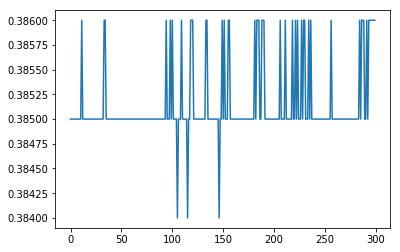

In [356]:
plt.plot(range(0,300),data_entry[:300])

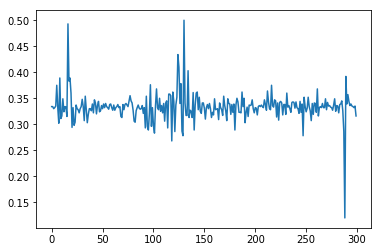

In [357]:
plt.plot(range(0,300),data_value[0:300])

In [355]:
r2_score(data_entry,data_value)

-17199.68778973578